In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import time
# 导入时间模块

import warnings
warnings.filterwarnings('ignore') 
# 不发出警告

from bokeh.io import output_notebook
output_notebook()
# 导入notebook绘图模块

from bokeh.plotting import figure,show
from bokeh.models import ColumnDataSource,HoverTool
# 导入bokeh绘图模块

Loading BokehJS ...

In [ ]:
'''
1、样本数据处理
   ** 按照一定规则生成了1万男性+1万女性样本：
   ** 在配对实验中，这2万个样本具有各自不同的个人属性（财富、内涵、外貌），每项属性都有一个得分
   ** 财富值符合指数分布，内涵和颜值符合正态分布
   ** 三项的平均值都为60分，标准差都为15分
要求：
① 构建函数实现样本数据生成模型，函数参数之一为“样本数量”，并用该模型生成1万男性+1万女性数据样本
   ** 包括三个指标：财富、内涵、外貌
② 绘制柱状图来查看每个人的属性分值情况
提示：
① 正态分布：np.random.normal(loc=60, scale=15, size=n)
② 指数分布：np.random.exponential(scale=15, size=n) + 45

'''

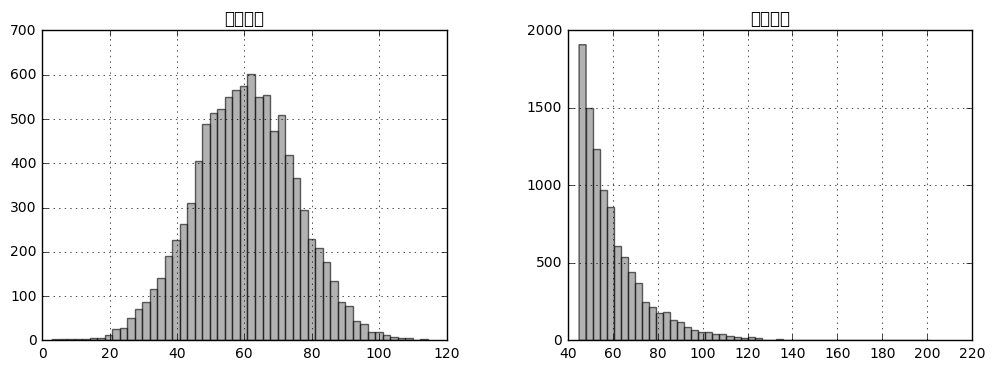

In [2]:
# 分别生成1万条随机数据，分别为正态分布、指数分布，要求数据均值为60，标准差为15

data_norm = pd.DataFrame({'正态分布':np.random.normal(loc = 60,scale = 15,size = 10000)})
data_exp = pd.DataFrame({'指数分布':np.random.exponential(scale = 15,size = 10000)+45})

fig,axes = plt.subplots(1,2,figsize = (12,4))
data_norm.hist(bins = 50,ax = axes[0],color = 'gray',alpha = 0.6,grid = True)
data_exp.hist(bins = 50,ax = axes[1],color = 'gray',alpha = 0.6,grid = True)
plt.show()

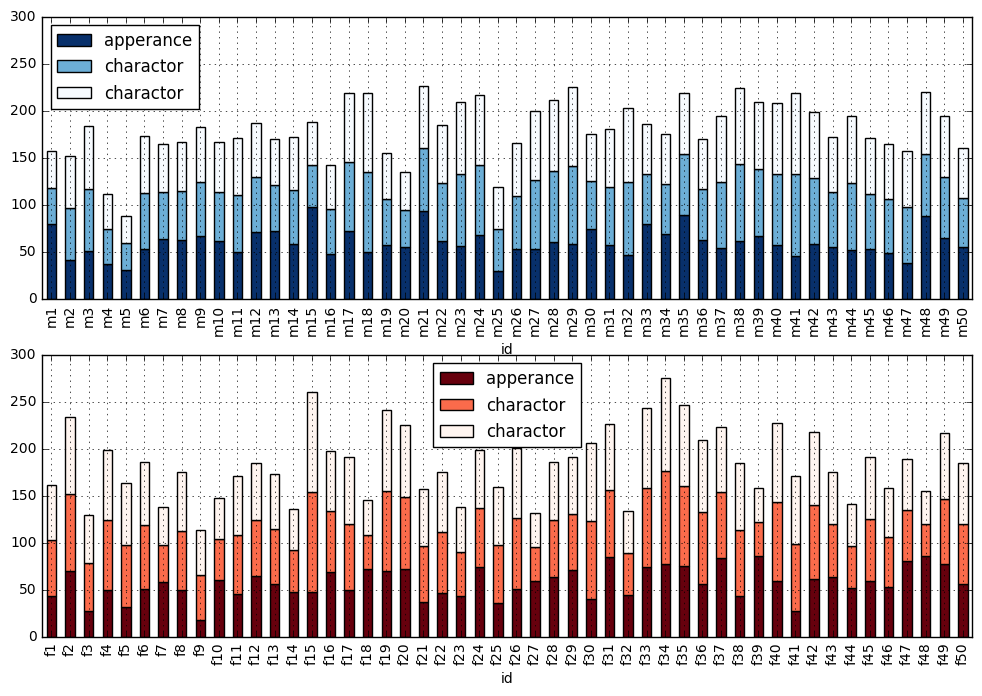

In [18]:
# 构建函数实现样本数据生成模型，函数参数之一为“样本数量”，并用该模型生成1万男性+1万女性数据样本

def create_sample(n,gender):
    sample_data = pd.DataFrame({'fortune':np.random.exponential(scale = 15,size = n)+45,
                                'apperance':np.random.normal(loc = 60,scale = 15,size = n),
                                'charactor':np.random.normal(loc = 60,scale = 15,size = n)},
                                index = [gender + str(i) for i in range(1,n+1)])
    sample_data['score'] = sample_data.sum(axis = 1)/3
    sample_data.index.name = 'id'
    return sample_data

sample_m = create_sample(10000,'m')
sample_f = create_sample(10000,'f')

fig,axes = plt.subplots(2,1,figsize = (12,8))
sample_m[['apperance','charactor','charactor']].iloc[:50].plot(ax = axes[0],ylim = [0,300],kind = 'bar',stacked = True,colormap = 'Blues_r',grid = True)
sample_f[['apperance','charactor','charactor']].iloc[:50].plot(ax = axes[1],ylim = [0,300],kind = 'bar',stacked = True,colormap = 'Reds_r',grid = True)

plt.show()

In [ ]:
'''

2、生成99个男性、99个女性样本数据，分别针对三种策略构建算法函数
   ** 择偶策略1：门当户对，要求双方三项指标加和的总分接近，差值不超过20分；
   ** 择偶策略2：男才女貌，男性要求女性的外貌分比自己高出至少10分，女性要求男性的财富分比自己高出至少10分；
   ** 择偶策略3：志趣相投、适度引领，要求对方的内涵得分在比自己低10分~高10分的区间内，且外貌和财富两项与自己的得分差值都在5分以内
   ** 每一轮实验中，我们将三种策略随机平分给所有样本，这里则是三种策略分别33人
   ** 这里不同策略匹配结果可能重合，所以为了简化模型 
   → 先进行策略1模拟，
   → 模拟完成后去掉该轮成功匹配的女性数据,再进行策略2模拟，
   → 模拟完成后去掉该轮成功匹配的女性数据,再进行策略3模拟
要求：
① 生成样本数据
② 给男性样本数据，随机分配策略选择 → 这里以男性为出发作为策略选择方
③ 尝试做第一轮匹配，记录成功的匹配对象，并筛选出失败的男女性进入下一轮匹配
④ 构建模型，并模拟1万男性+1万女性的配对实验
⑤ 通过数据分析，回答几个问题：
   ** 百分之多少的样本数据成功匹配到了对象？
   ** 采取不同择偶策略的匹配成功率分别是多少？
   ** 采取不同择偶策略的男性各项平均分是多少？
提示：
① 择偶策略评判标准：
   ** 若匹配成功，则该男性与被匹配女性在这一轮都算成功，并退出游戏
   ** 若匹配失败，则该男性与被匹配女性再则一轮都算失败，并进入下一轮
   ** 若同时多个男性选择了同一个女性，且满足成功配对要求，则综合评分高的男性算为匹配成功
② 构建空的数据集，用于存储匹配成功的数据
③ 每一轮匹配之后，删除成功匹配的数据之后，进入下一轮，这里删除数据用df.drop()
④ 这里建议用while去做迭代 → 当该轮没有任何配对成功，则停止实验
'''

In [19]:
sample_m_test = create_sample(99,'m')
sample_f_test = create_sample(99,'f')
#设置好样本数据

sample_m_test['strategy'] = np.random.choice([1,2,3],99)
# 给男性赋值策略选择
# 1 → 择偶策略1
# 2 → 择偶策略2
# 3 → 择偶策略

In [20]:
# 择偶策略，测试

match_success = pd.DataFrame(columns = ['m','f','round_n','strategy'])
# 构建空的数据集，用于存储匹配成功的数据

round1_f = sample_f_test.copy()
# 复制女性样本数据

round1_m = sample_m_test.copy()
round1_m['choice'] = np.random.choice(round1_f.index,len(round1_f))
# 复制男性样本数据，并做匹配选择

round1_match = pd.merge(round1_m,round1_f,left_on = 'choice',right_index = True)
round1_match['app_dis'] = np.abs(round1_match['apperance_x'] - round1_match['apperance_y'])
round1_match['cha_dis'] = np.abs(round1_match['charactor_x'] - round1_match['charactor_y'])
round1_match['for_dis'] = np.abs(round1_match['fortune_x'] - round1_match['fortune_y'])
round1_match['score_dis'] = np.abs(round1_match['score_x'] - round1_match['score_y'])


# ① 策略1：门当户对，要求双方三项指标加和的总分接近，差值不超过20分；
round1_s1_m = round1_match[round1_match['strategy']==1]
round1_s1_success = round1_s1_m[round1_s1_m['score_dis']<=20].groupby('choice').max()
ruond1_s1_success = pd.merge(round1_s1_success,round1_m.reset_index(),left_on = 'score_x',right_on = 'score')[['id','choice']]


round1_s1_success

,apperance_x,charactor_x,fortune_x,score_x,strategy,apperance_y,charactor_y,fortune_y,score_y,app_dis,cha_dis,for_dis,score_dis
choice,,,,,,,,,,,,,
f13,75.890931,69.118841,67.258015,70.755929,1,59.454641,54.812190,54.423277,56.230036,16.436290,14.306651,12.834738,14.525893
f14,53.584177,90.409731,48.170769,64.054893,1,80.645287,74.448921,45.234583,66.776263,27.061109,15.960811,2.936186,2.721371
f18,58.164786,76.740313,60.775890,63.156363,1,37.854388,42.521477,52.791575,44.389147,20.310398,34.218836,7.984314,18.767216
f2,36.548950,57.713378,48.263092,47.508473,1,53.142988,70.394625,60.167007,61.234873,16.594038,12.681248,11.903915,13.726400
f20,69.928199,67.608838,49.901955,62.479664,1,46.347571,57.183631,108.294936,70.608712,23.580628,10.425207,58.392981,8.129049
f22,69.511871,53.151501,85.646347,69.436573,1,67.436268,55.592759,65.673817,62.900948,2.075604,2.441258,19.972530,6.535625
f24,68.959437,56.834549,123.785444,78.153067,1,57.399138,80.275883,45.333868,61.002963,11.560298,34.451653,78.451576,17.150104
f28,100.358104,66.755887,49.896435,72.336809,1,74.870388,67.467905,65.267824,69.202039,25.487715,0.712017,15.371389,3.134770
f29,49.605868,47.675555,66.176363,54.485929,1,63.780078,45.879304,45.473135,51.710839,14.174210,1.796251,20.703228,2.775090
